# Neural & Behavioral Modeling - Week 11 (Exercises)
by 林子堯 (r08227112@ntu.edu.tw)

In [17]:
# Upgrade PyTorch if necessary:
! conda install -y pytorch-cpu torchvision-cpu -c pytorch

/bin/bash: conda: command not found


In [18]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [19]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
if(t.cuda.is_available()):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
else:
    print('No GPU')

PyTorch version: 1.7.0+cu101
Device  0 : Tesla P4
Current: Device  0


## 1 Tuning the performance of a neural net (10 points)

### 1.1 Problem
In the section 4.1 of 11_examples.ipynb, the neural network implemented in NumPy with two hidden layers could reach 90% classification accuracy on the MNIST training data only within 3 learning epochs:

<pre>
model=MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100], output_size=10,
                          weight_init_std=weight_init_std, use_batchnorm=True, use_dropout=True)
</pre>

However, in the section 4.2, a similar network implemented in PyTorch did not reached 90% clasification accuracy model on the MNIST training data: 

<pre>
model = t.nn.Sequential(
    t.nn.Linear(D_in, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, D_out),
    t.nn.Softmax()
)
</pre>

Your goal is to do whatever you can to help the PyTorch net reach 90% classification accuracy on the MNIST training data within 50 or less epochs.

### 1.2 Tips

First try to eliminate the differences between the NumPy net and the PyTorch net:

(1) The PyTorch version did not use 50% Dropout.

(2) The PyTorch used Adam with a learning rate of 1e-4 as an optimizer instead of SGD with a learning rate of 1e-2.

(3) The PyTroch version did not use shuffled batch (100 samples) in each training epoch.

(4) The NumPy version used He initialization on NORMAL W and ZEROED b:
<pre>
    def __init_weight(self, weight_init_std):

        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                <font color="red">scale = np.sqrt(2.0 / all_size_list[idx - 1])  # for ReLu</font>
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # for Sigmoid
            <font color="blue">self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])</font>
</pre>

However, the PyTroch version used Xavier initialization on UNIFORM W and b for <a href="https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L44-L48">linear layers</a>:

<pre>
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        <font color="red">self.reset_parameters()</font>
<font color="blue">
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
</font>
</pre>

(5)If removal of the above differences does not help, look for other differences or do whatever you can to accelerate learning of the PyTorch net.

<b>(6) Do not waste your time on checking out training results after 50 epochs! They have nothing to do with your goal here.</b>

### 1.3 Your codes and discussions

#### 1.3.1 The MNIST dataset

In [20]:
# Download the dataset:
import urllib.request
urllib.request.urlretrieve('https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz','mnist.pkl.gz')

('mnist.pkl.gz', <http.client.HTTPMessage at 0x7f19ab80e390>)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: invalid escape sequence '\>'
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: invalid escape sequence '\?'
  after removing the cwd from sys.path.


(50000, 784) (50000,) (10000, 784) (10000,)
0.0 0.99609375 0 9


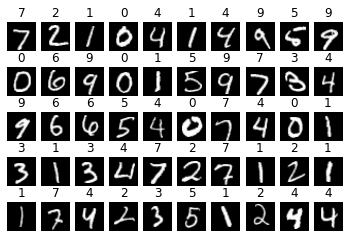

In [21]:
# Load the dataset:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
f.close()
x_train,y_train=train_set[0],train_set[1]
x_valid,y_valid=valid_set[0],valid_set[1]
x_test,y_test=test_set[0],test_set[1]

# Examine the dataset:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(np.min(x_train),np.max(x_train),np.min(y_train),np.max(y_train))
for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(y_test[i]));
    axis('off')
    
# Transform NumPy arrays to PyTorch tensors:
use_cuda=t.cuda.is_available()

X_train=t.from_numpy(x_train)
Y_train=t.from_numpy(y_train)
X_test=t.from_numpy(x_test)
Y_test=t.from_numpy(y_test)

if(use_cuda):
    X_train=X_train.cuda()
    Y_train=Y_train.cuda()
    X_test=X_test.cuda()
    Y_test=Y_test.cuda()

#### 1.3.2 Your systematic explorations

原始老師在 [11_exercises.ipnb](https://github.com/xup6y3ul6/Neural-and-Behavioral-Modeling/blob/main/11_Deep-learning%20Neural%20Networks%20(1-4)%20Fully-Connected%20Multilayer%20Perceptron%20(MLP)/11_examples.ipynb) 的範例中，使用 Numpy 寫神經網路的模型來預測 MNIST 的訓練集，比起用 Pytorch 套件對相似的模型結構來說，學習效率要快許多。如下圖所示：

<figure>
  <img src="https://github.com/xup6y3ul6/Neural-and-Behavioral-Modeling/blob/main/11_Deep-learning%20Neural%20Networks%20(1-4)%20Fully-Connected%20Multilayer%20Perceptron%20(MLP)/numpy_acc.png?raw=true" alt="drawing" width="200"/>
  <figcaption>Fig1. Accuracy of 3-layer-NN by Numpy</figcaption>
</figure>
<figure>
  <img src="https://github.com/xup6y3ul6/Neural-and-Behavioral-Modeling/blob/main/11_Deep-learning%20Neural%20Networks%20(1-4)%20Fully-Connected%20Multilayer%20Perceptron%20(MLP)/pytorch_acc.png?raw=true" alt="drawing" width="200"/>
  <figcaption>Fig2. Accuracy of 2-layer-NN by Pytorch</figcaption>
</figure>

前者在少量的 epoch 次數就達到　9 成的準確率，但後者似乎需要花更多的時間。然而這兩模型的參數與超參數設定上其實有許多差異：

| Diff. | Numpy | Pytorch |
|----|:----:|:----:|
|1. Droupout | yes ($p=.5$) | no ($p=0$) |
|2a. Optimizer | SDG | Adam |
|2b. Learning rate | $10^{-2}$ | $10^{-4}$|
|3. Batch size | 100 | 50000 (all traing size)|
|4. Initialization | Xavier | He |
|5. Model | 3 layers | 2 layers* |

*對於上面的第五點，如果我將 Pytorch 改為 3 layers 的模型，其學習效率也沒有明顯改善。

雖然說我個人認為這樣的比較其實蠻不公平的，Numpy 是以 shuffle batch (100 samples) 來進行參數的更新，因此計算一次 epoch 會經歷 $500 (= 50000/100)$ 次的迭代學習。然而在 Pytorch 的部分，每一次的迭代會用所有的 training data (50000 samples)，因此迭代一次就會算經歷一次 epoch！因此，我在老師原始的範例中，除了本來會顯示 epoch 外還多加顯示迭帶次數 (見 Fig 1 & 2)，其實可以觀察到如果我們比的是跟新次數的話，在同樣 500 次或是 1000 次的迭帶更新下，Numpy 和 Pytorch 分別在這兩個模型中準確率實際上是差不多的。所以我個人認為即便在這樣設計下，「Pytorch 沒有輸」!



但還是要寫作業，為了改善 Pytorch 的「學習效率」，我分別針對上述差異點進行改良：

In [22]:
# Tip4: used He initialization on NORMAL W and ZEROED b
def init_normal(m):
  '''
  initialization function, first checks the module type,
  then applies the desired changes to the weights
  https://pytorch.org/docs/stable/nn.init.html
  '''
  if type(m) == t.nn.Linear:  
    t.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
    t.nn.init.zeros_(m.bias)

In [23]:
def runModel(batch_size = X_train.shape[0], max_epochs = 5, learning_rate = 1e-4, \
             droupout_rate = 0, initialize = "Xavier", optim = "Adam"):
  # Here is the PyTorch net:

  D_in, H, D_out = 784,100,10
  train_size = X_train.shape[0]
  
  # Training the network:
  model = t.nn.Sequential(
    t.nn.Linear(D_in, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Dropout(p=droupout_rate), # Tip1: add dropout layer with p (no dropout if p = 0)
    t.nn.Linear(H, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Dropout(p=droupout_rate), # Tip1: add dropout layer with p (no dropout if p = 0)
    t.nn.Linear(H, D_out),
    t.nn.Softmax()
  )
                              
  # Tip4: use the modules apply function to recursively apply the "He" initialization
  if initialize == "He":
    model.apply(init_normal)

  loss_fn = t.nn.CrossEntropyLoss()
  
   
  # Tip2a: change optimzer SDG (not momentum) or Adam, and
  # Tip2b: change learning rate
  if optim == "SGD":
    optimizer = t.optim.SGD(model.parameters(), lr=learning_rate, momentum=0) 
  elif optim == "Adam":
    optimizer = t.optim.Adam(model.parameters(), lr=learning_rate) #https://pytorch.org/docs/stable/optim.html

  if(use_cuda):
    model = model.cuda()
    loss_fn = loss_fn.cuda()

  iter_per_epoch = max(train_size / batch_size, 1) #
  epoch_cnt = 0 #

  for i in range(100000000): #
    # Tip3: use shuffled batch (n samples) in each training epoch
    batch_mask = t.multinomial(t.ones(train_size), batch_size)
    X_batch = X_train[batch_mask]
    Y_batch = Y_train[batch_mask]

    # Forward pass:
    # Y_pred = model(X_train)
    Y_pred = model(X_batch)

    loss = loss_fn(Y_pred, Y_batch)
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass:
    loss.backward()

    # Update the weights using gradient descent:
    optimizer.step()
    
    # Check training accuracy:
    if i % iter_per_epoch == 0:
      Y_pred = model(X_train) # Y_pred.shape=[50000,10]
      Y_pred = t.max(Y_pred,1)[1] # Y_pred.shape=[50000]
      print('epoch ',epoch_cnt, '(iter: ', i, ') | train_acc:'\
            ,(Y_pred==Y_train).sum().item()/Y_train.shape[0])
      epoch_cnt += 1
      if epoch_cnt >= max_epochs:
        break    

#### 1.4.1 原始版本

使用 pytorch 三層的 neural network model，其中這是老師一開始的設置，包括：

- Tip1: No dropout
- Tip2: Optimizer = "Adam" with learing_rate = 0.0001
- Tip3: Use all train_data (50000 samples) in each training (1 epoch = 1 iteration)
- Tip4: Initialize weights by Xaiver method
- Diff5: Use 3-layer-nn

結果如下

In [24]:
runModel(batch_size = 50000, max_epochs = 20, learning_rate = 1e-4, \
         droupout_rate = 0, initialize = "Xavier", optim = "Adam")

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch  0 (iter:  0 ) | train_acc: 0.06358
epoch  1 (iter:  1 ) | train_acc: 0.07642
epoch  2 (iter:  2 ) | train_acc: 0.09252
epoch  3 (iter:  3 ) | train_acc: 0.11322
epoch  4 (iter:  4 ) | train_acc: 0.13696
epoch  5 (iter:  5 ) | train_acc: 0.16578
epoch  6 (iter:  6 ) | train_acc: 0.19684
epoch  7 (iter:  7 ) | train_acc: 0.2302
epoch  8 (iter:  8 ) | train_acc: 0.26096
epoch  9 (iter:  9 ) | train_acc: 0.29344
epoch  10 (iter:  10 ) | train_acc: 0.32372
epoch  11 (iter:  11 ) | train_acc: 0.35078
epoch  12 (iter:  12 ) | train_acc: 0.37712
epoch  13 (iter:  13 ) | train_acc: 0.4014
epoch  14 (iter:  14 ) | train_acc: 0.4238
epoch  15 (iter:  15 ) | train_acc: 0.445
epoch  16 (iter:  16 ) | train_acc: 0.46362
epoch  17 (iter:  17 ) | train_acc: 0.48226
epoch  18 (iter:  18 ) | train_acc: 0.49918
epoch  19 (iter:  19 ) | train_acc: 0.51504


可以發現 (如果是用 epoch 來看的話啦) 此模型的學習效率是緩慢提升，當然它迭代更新的次數也沒那麼多。

如果我們將模型設置改為老師用 Numpy 時的範例...


#### 1.4.2 Numpy 時的設置

在此我們改變我們模型的參數設定，包括：

- Tip1: Use dropout ($p = 0.5$)
- Tip2: Optimizer = "SGD" with learing_rate = 0.01
- Tip3: Shuffled batch with 100 samples in each train (1 epoch = 500 iteration)
- Tip4: Initialize weights by He method
- Diff5: Use 3-layer-nn

結果如下

In [25]:
runModel(batch_size = 100, max_epochs = 10, learning_rate = 1e-2, \
         droupout_rate = 0.5, initialize = "He", optim = "SGD")

epoch  0 (iter:  0 ) | train_acc: 0.0866


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch  1 (iter:  500 ) | train_acc: 0.24862
epoch  2 (iter:  1000 ) | train_acc: 0.44388
epoch  3 (iter:  1500 ) | train_acc: 0.53616
epoch  4 (iter:  2000 ) | train_acc: 0.59384
epoch  5 (iter:  2500 ) | train_acc: 0.64062
epoch  6 (iter:  3000 ) | train_acc: 0.67304
epoch  7 (iter:  3500 ) | train_acc: 0.69718
epoch  8 (iter:  4000 ) | train_acc: 0.71674
epoch  9 (iter:  4500 ) | train_acc: 0.73102


然而出乎意料的是，既便模型的超參數都設置一樣了，學習效率似乎沒有像老師 Numpy 範例中一樣快速的就提升到 9 成以上。因此，接下來的 1.4.3-1.4.7 節，我將分別把 1.4.2 中的參數輪流改回原始 1.4.1 時的參數，來檢驗究竟何種參數與超參數是重大的影響因子，或是在怎樣的配置下才能使學習效率有快速的提升。


#### 1.4.3 Batch size 改回 training_data 的大小

In [26]:
runModel(batch_size = X_train.shape[0], max_epochs = 10, learning_rate = 1e-2, \
         droupout_rate = 0.5, initialize = "He", optim = "SGD")

epoch  0 (iter:  0 ) | train_acc: 0.11728
epoch  1 (iter:  1 ) | train_acc: 0.11742


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch  2 (iter:  2 ) | train_acc: 0.12004
epoch  3 (iter:  3 ) | train_acc: 0.119
epoch  4 (iter:  4 ) | train_acc: 0.11908
epoch  5 (iter:  5 ) | train_acc: 0.1165
epoch  6 (iter:  6 ) | train_acc: 0.121
epoch  7 (iter:  7 ) | train_acc: 0.1208
epoch  8 (iter:  8 ) | train_acc: 0.11968
epoch  9 (iter:  9 ) | train_acc: 0.12088


Batch size 過大，使得每次 epoch 的迭代次數變少，當然學習效率也沒有顯著提升，正確率遲滯不前。

#### 1.4.4 Learning rate 改回 0.0001

In [27]:
runModel(batch_size = 100, max_epochs = 10, learning_rate = 1e-4, \
         droupout_rate = 0.5, initialize = "He", optim = "SGD")

epoch  0 (iter:  0 ) | train_acc: 0.10892


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch  1 (iter:  500 ) | train_acc: 0.11086
epoch  2 (iter:  1000 ) | train_acc: 0.11006
epoch  3 (iter:  1500 ) | train_acc: 0.1107
epoch  4 (iter:  2000 ) | train_acc: 0.1137
epoch  5 (iter:  2500 ) | train_acc: 0.11628
epoch  6 (iter:  3000 ) | train_acc: 0.11614
epoch  7 (iter:  3500 ) | train_acc: 0.11862
epoch  8 (iter:  4000 ) | train_acc: 0.123
epoch  9 (iter:  4500 ) | train_acc: 0.12318


Learning rate 過小，可能使得參數的更新過於緩慢，因此也可發現學習效率非常的差。

然而另一方面，如果我用最原始 (1.4.1) 的設定，但只將 learning rate 改成 0.01， 

In [28]:
runModel(batch_size = X_train.shape[0], max_epochs = 10, learning_rate = 1e-2, \
         droupout_rate = 0, initialize = "Xavier", optim = "Adam")

epoch  0 (iter:  0 ) | train_acc: 0.7032
epoch  1 (iter:  1 ) | train_acc: 0.75396


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch  2 (iter:  2 ) | train_acc: 0.77052
epoch  3 (iter:  3 ) | train_acc: 0.78872
epoch  4 (iter:  4 ) | train_acc: 0.80432
epoch  5 (iter:  5 ) | train_acc: 0.81494
epoch  6 (iter:  6 ) | train_acc: 0.82452
epoch  7 (iter:  7 ) | train_acc: 0.83426
epoch  8 (iter:  8 ) | train_acc: 0.84584
epoch  9 (iter:  9 ) | train_acc: 0.85904


就能觀察到學習效率會有顯著的進步，即便我們每次迭代都用整個 training data！因此，在前面 1.4.3 節我們以為學習效率不好以為是因為 batch size 設置太大，但有可能其實是因為搭配到不好的 learning rate 才造成此結果。總結來說，這兩者的組合會是此模型學習上是非常重要的因素之一。  

#### 1.4.5 沒有 droupout (or droupout rate = 0)

In [29]:
runModel(batch_size = 100, max_epochs = 10, learning_rate = 1e-2, \
     droupout_rate = 0, initialize = "He", optim = "SGD")

epoch  0 (iter:  0 ) | train_acc: 0.11118


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch  1 (iter:  500 ) | train_acc: 0.66962
epoch  2 (iter:  1000 ) | train_acc: 0.76196
epoch  3 (iter:  1500 ) | train_acc: 0.79272
epoch  4 (iter:  2000 ) | train_acc: 0.81762
epoch  5 (iter:  2500 ) | train_acc: 0.88556
epoch  6 (iter:  3000 ) | train_acc: 0.90386
epoch  7 (iter:  3500 ) | train_acc: 0.9118
epoch  8 (iter:  4000 ) | train_acc: 0.91764
epoch  9 (iter:  4500 ) | train_acc: 0.92226


發現其實沒有加入 droupout 這層反而學習效率比起 1.4.2 時要還得快！雖然之後預測上可能會有 overfitting 的顧慮，但在這邊我們要讓準確率快速的極大化，因此有充足多的參數 (也就是不要隨機失去參數) 可能是重要的因素。


#### 1.4.6 參數的初始設定改回 Xavier method

In [30]:
runModel(batch_size = 100, max_epochs = 10, learning_rate = 1e-2, \
     droupout_rate = 0.5, initialize = "Xavier", optim = "SGD")

epoch  0 (iter:  0 ) | train_acc: 0.11548


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch  1 (iter:  500 ) | train_acc: 0.40736
epoch  2 (iter:  1000 ) | train_acc: 0.5644
epoch  3 (iter:  1500 ) | train_acc: 0.65242
epoch  4 (iter:  2000 ) | train_acc: 0.68968
epoch  5 (iter:  2500 ) | train_acc: 0.71136
epoch  6 (iter:  3000 ) | train_acc: 0.72478
epoch  7 (iter:  3500 ) | train_acc: 0.74788
epoch  8 (iter:  4000 ) | train_acc: 0.77688
epoch  9 (iter:  4500 ) | train_acc: 0.78994


似乎用 Xavier mehhod (1.4.6) 或使用 He method (1.4.2) 的學習效率差不多，雖然老師給的參考資料中會建議如果使 ReLU 作為活化函數使用 He method 比起用 Xavier method 來說，較能減低「梯度消失」的問題，但我猜測在 1.4.6 與 1.4.2 之間的差異不大之可能的原因在於，我們這邊只有 3 層的神經網路，還不至於使活化性的偏差過大，所以在這邊的準確率也差不多。


#### 1.4.7 Optimizer 改回 Adam method

In [31]:
runModel(batch_size = 100, max_epochs = 10, learning_rate = 1e-2, \
     droupout_rate = 0.5, initialize = "He", optim = "Adam")

epoch  0 (iter:  0 ) | train_acc: 0.16642


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch  1 (iter:  500 ) | train_acc: 0.88798
epoch  2 (iter:  1000 ) | train_acc: 0.8983
epoch  3 (iter:  1500 ) | train_acc: 0.90814
epoch  4 (iter:  2000 ) | train_acc: 0.9082
epoch  5 (iter:  2500 ) | train_acc: 0.91216
epoch  6 (iter:  3000 ) | train_acc: 0.91622
epoch  7 (iter:  3500 ) | train_acc: 0.91444
epoch  8 (iter:  4000 ) | train_acc: 0.91842
epoch  9 (iter:  4500 ) | train_acc: 0.91858


這邊就很顯然的可觀察到，Adam method 還是比起 SGD 來說，馬上就能達到超高的正確率。


#### 1.4.8 最佳的設置

綜合上述的觀察，能得到下方結論

- Batch size 要搭配好的 learning rate，這兩者的組合會大大影響學習效率 
- 有 dropout 不會增加學習效率，但有 overfitting 的可能
- 3-layer-nn 用 ReLU 作為活化函數，參數初始值使用 He 或是 Xavier 沒有太大差異
- Optimeizer 選用 Adam 比 SGD 要更快達到最佳值

經過一些嘗試後，下方參數與超參數的配置是我目前得到最快的學習效率，只需 10 次的 epcoh 就能達到幾乎 99% 的正確率了！ 

In [35]:
runModel(batch_size = 1000, max_epochs = 10, learning_rate = 1e-2, \
     droupout_rate = 0, initialize = "He", optim = "Adam")

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch  0 (iter:  0 ) | train_acc: 0.58542
epoch  1 (iter:  50 ) | train_acc: 0.95414
epoch  2 (iter:  100 ) | train_acc: 0.9687
epoch  3 (iter:  150 ) | train_acc: 0.97532
epoch  4 (iter:  200 ) | train_acc: 0.9799
epoch  5 (iter:  250 ) | train_acc: 0.98174
epoch  6 (iter:  300 ) | train_acc: 0.9855
epoch  7 (iter:  350 ) | train_acc: 0.98628
epoch  8 (iter:  400 ) | train_acc: 0.98814
epoch  9 (iter:  450 ) | train_acc: 0.98964
